In [1]:
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
# Read the NLS aligned motifs

file_path ='./NLS_sequences_padded.txt'

NLS_sequences = []

with open(file_path, 'r', encoding = 'utf-8') as f:
  for line in f:
    NLS_sequences.append(line.strip())

In [36]:
NLS_sequences

['KRTVETEAVQMLKDIKKE------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------',
 'KLKEKLK-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------',
 'RREFGDSKRVFGERRRN-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------',
 'KKR---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------',
 'KKR---------------------------------------------------------------------------------------------------------------------------------------------------------------

In [3]:
background = {'A':0.0777,
              'C':0.0157,
              'D':0.053,
              'E':0.0656,
              'F':0.0405,
              'G':0.0691,
              'H':0.0227,
              'I':0.0591,
              'K':0.0595,
              'L':0.096,
              'M':0.0238,
              'N':0.0427,
              'P':0.0469,
              'Q':0.0393,
              'R':0.0526,
              'S':0.0694,
              'T':0.055,
              'V':0.0667,
              'W':0.0118,
              'Y':0.0311}

In [4]:
class GenericPositionMatrix:
    """Base class for position matrix operations on protein motifs."""
    standard_amino_acids = 'ACDEFGHIKLMNPQRSTVWY'  # 20 standard amino acids

    def __init__(self, aligned_sequences):
        self.length = len(aligned_sequences[0])  
        self._validate_sequences(aligned_sequences)  
        self.matrix = self._calculate_position_counts(aligned_sequences)
        self.num_sequences = len(aligned_sequences)
        self.effective_length = self.find_effective_length()  # Calculate effective length after all setups

    def _validate_sequences(self, aligned_sequences):
        if not all(len(seq) == self.length for seq in aligned_sequences):
            raise ValueError("Data has inconsistent lengths.")

    def _calculate_position_counts(self, aligned_sequences):
        aa_counts = defaultdict(lambda: [0] * self.length)
        for seq in aligned_sequences:
            for position, amino_acid in enumerate(seq):
                aa_counts[amino_acid][position] += 1
        return aa_counts

    def find_effective_length(self, threshold=0.9):
        """Dynamically determine the effective NLS length, excluding padding."""
        for position in range(self.length - 1, -1, -1):
            padding_ratio = self.matrix['-'][position] / self.num_sequences
            if padding_ratio < threshold:
                return position + 1  # Return length excluding padding
        return self.length  # Return full length if no padding detected

class PositionWeightMatrix(GenericPositionMatrix):
    """Supports frequency calculations for protein motifs."""

    def normalize(self, background_frequencies=background, pseudocount_factor=1):
        normalized_matrix = {aa: [0.0] * self.effective_length for aa in self.standard_amino_acids}
        total_counts = [0] * self.effective_length

        for aa in self.standard_amino_acids:
            for position in range(self.effective_length):
                pseudocount = background_frequencies[aa] * pseudocount_factor
                count = self.matrix.get(aa, [0] * self.effective_length)[position] + pseudocount
                normalized_matrix[aa][position] = count
                total_counts[position] += count

        for aa, counts in normalized_matrix.items():
            for position, count in enumerate(counts):
                normalized_matrix[aa][position] = count / total_counts[position] if total_counts[position] else 0

        self.matrix = normalized_matrix

    def log_odds(self, background_frequencies=background):
        background_frequencies = background
        # or {aa: 1.0 / len(self.standard_amino_acids) for aa in self.standard_amino_acids}
        log_odds_matrix = {aa: [0] * self.effective_length for aa in self.standard_amino_acids}

        for aa in self.standard_amino_acids:
            for position in range(self.effective_length):
                p = self.matrix[aa][position]
                b = background_frequencies.get(aa, 0)
                score = math.log(p / b, 2) if p > 0 else -math.inf
                log_odds_matrix[aa][position] = score

        return PositionSpecificScoringMatrix(log_odds_matrix, self.effective_length)

class PositionSpecificScoringMatrix:
    """Scores sequences against a Position Specific Scoring Matrix (PSSM)."""

    def __init__(self, matrix, length):
        self.matrix = matrix
        self.length = length
        self.standard_amino_acids = 'ACDEFGHIKLMNPQRSTVWY'

    def __str__(self):
        lines = ["   " + " ".join(f"{i:6d}" for i in range(self.length))]
        for amino_acid in self.standard_amino_acids:
            line = f"{amino_acid}: " + " ".join(f"{self.matrix[amino_acid][i]:6.2f}" for i in range(self.length))
            lines.append(line)
        return "\n".join(lines)

    def calculate(self, sequence):
        """Calculate the PSSM score for a given protein sequence."""
        # Initial checks and setup
        sequence = sequence.upper()
        if any(aa not in self.standard_amino_acids for aa in sequence):
            raise ValueError("Sequence contains invalid amino acids for this PSSM.")

        scores = np.empty(len(sequence) - self.length + 1, dtype=np.float32)
        for offset in range(len(scores)):
            score = sum(self.matrix[aa][position] for position, aa in enumerate(sequence[offset:offset + self.length]) if aa in self.matrix)
            scores[offset] = score
        return scores

    def search(self, sequence, threshold=0.0):
        """Find hits in the sequence with PSSM score above a given threshold."""
        sequence = sequence.upper()
        potential_hits = []
        scores = self.calculate(sequence)
        for i, score in enumerate(scores):
            if score >= threshold:
                # yield start + i, score
                potential_hits.append((i, score))

        potential_hits.sort(key=lambda x: x[1], reverse=True)
        return potential_hits

In [5]:
fpm = PositionWeightMatrix(NLS_sequences)
fpm.normalize()  
pssm = fpm.log_odds()
print(pssm)

        0      1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16     17
A:  -3.40  -1.20  -1.20  -1.14  -1.16  -1.39  -1.21  -0.31  -0.45  -0.37  -0.98  -0.66  -0.33  -1.97  -0.26  -0.53  -1.36  -0.57
C:  -2.42  -1.83  -1.41  -2.36  -1.59  -0.99  -1.39  -1.66  -1.09  -0.60  -1.17  -1.60   0.26  -0.16  -8.41  -8.31  -8.06  -0.43
D:  -2.00  -3.00  -1.52  -5.08  -0.97  -0.57  -0.88  -0.20  -0.53  -0.77  -1.51  -0.77  -1.13  -0.43  -1.35  -0.48  -2.21   0.51
E:  -2.39  -1.84  -1.08  -0.81  -0.35  -0.38  -0.56  -0.23   0.77   0.74   0.03   0.94  -0.22  -1.21  -1.15  -0.67  -0.95  -0.49
F:  -4.76  -4.18  -1.69  -1.40  -1.37  -2.03  -0.49  -1.03  -0.76  -0.96  -0.22  -2.95  -1.11  -0.26  -1.45  -2.65  -8.06  -0.48
G:  -2.31  -2.03  -0.94  -0.45  -0.79  -0.57  -1.04  -1.07  -0.91  -0.81  -0.31  -0.93  -0.88  -1.80  -0.96   0.14  -1.02  -0.98
H:  -1.63  -0.86  -0.62  -0.64  -0.38  -0.61   0.61   0.30  -1.04  -0.28   0.17  -1.55  -1.08   0

In [6]:
# Plot customized heatmap
def plot_heatmap(pssm, width=10, height=30):
    plt.figure(figsize=(width, height))
    ax = sns.heatmap(pssm, annot=False, cmap='viridis', linewidths=.5,
                    xticklabels=pssm.columns)


    ax.xaxis.tick_top()

    ax.set_xticklabels(pssm.columns, ha="left")
    plt.tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=True, labeltop=True)

    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    # Title and labels
    plt.title('PSSM Heatmap', y=1.05)
    plt.xlabel('Amino Acids', labelpad=20)
    plt.ylabel('Position')

    plt.tight_layout()

    plt.show()

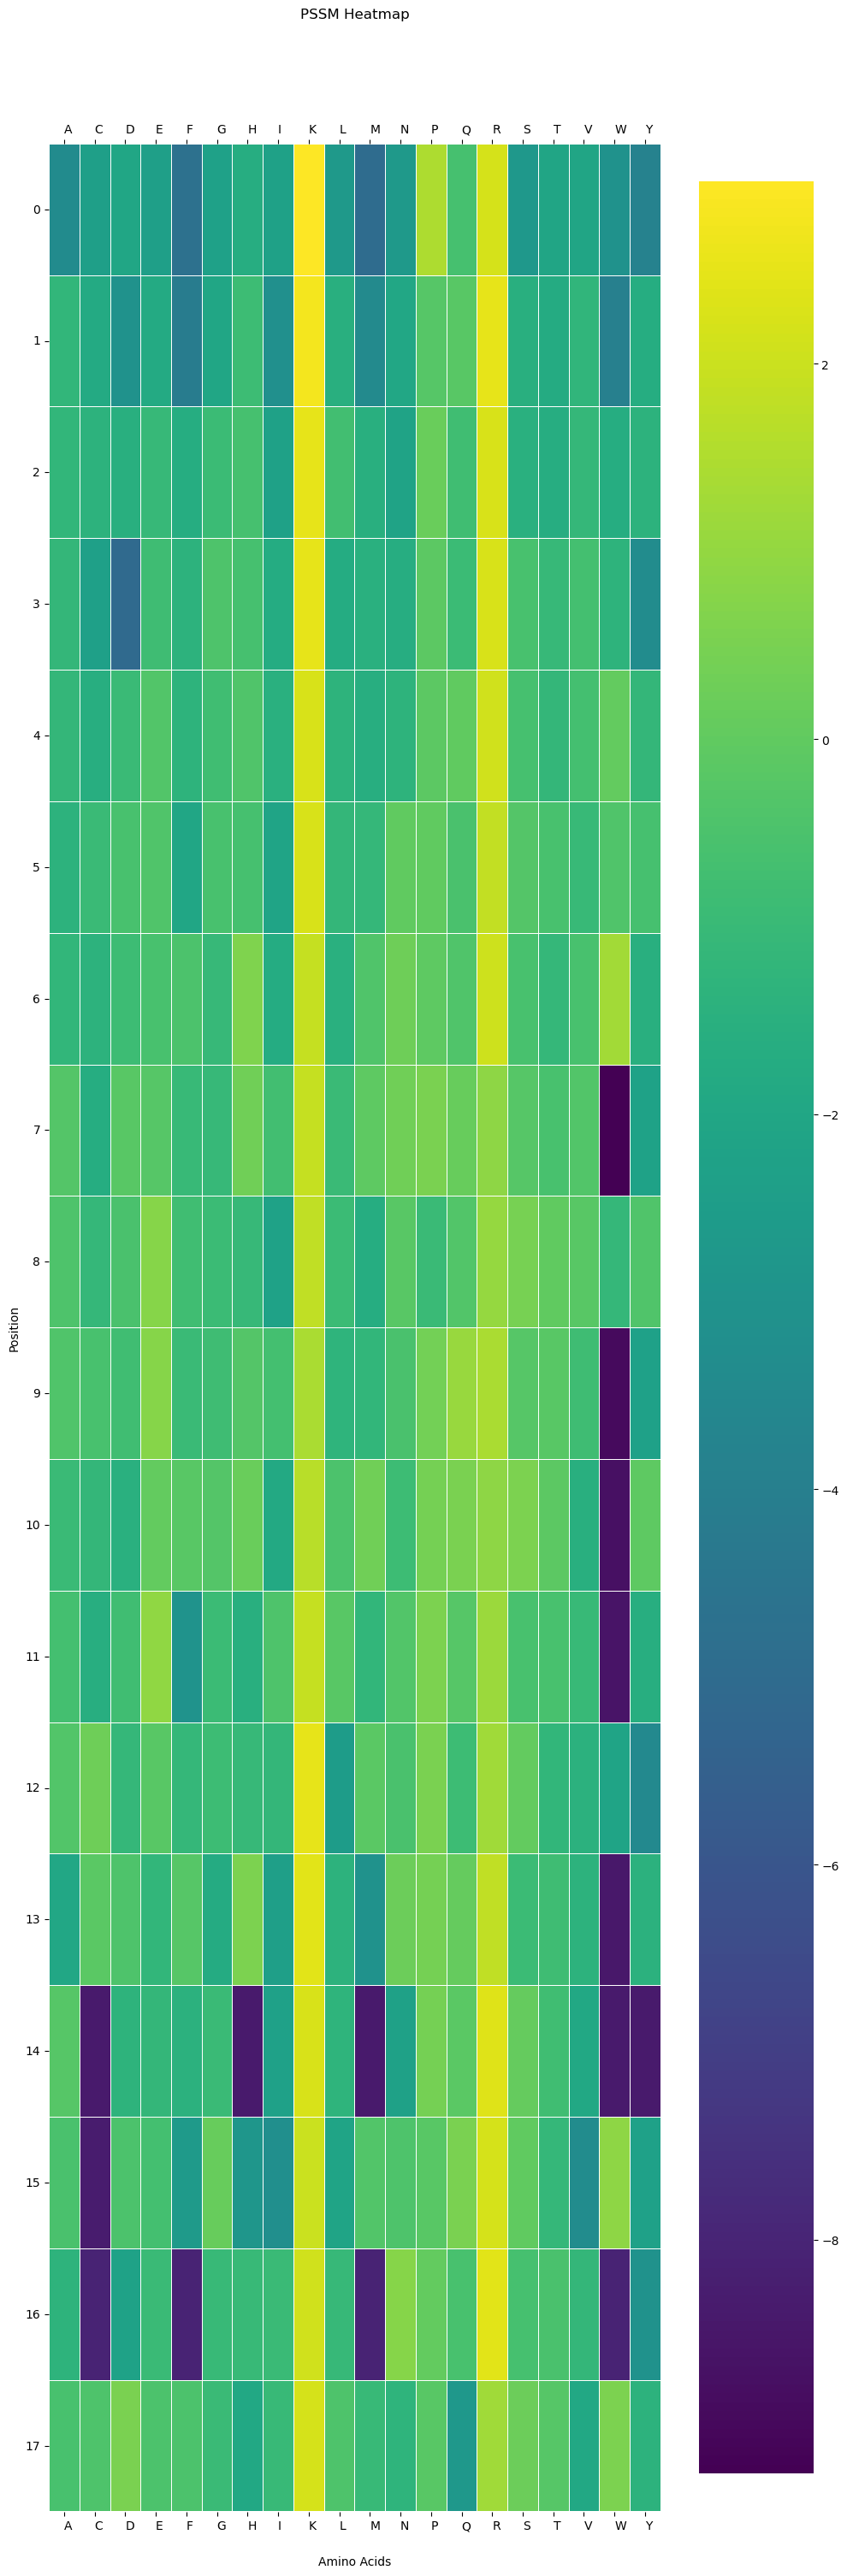

In [50]:
df_pssm = pd.DataFrame(pssm.matrix)

plot_heatmap(df_pssm,10,30)

In [7]:
def compute_scores(pssm, sequence, threshold=3):
    sequence_scores = pssm.calculate(sequence)
    results = pssm.search(sequence,threshold)
    return sequence_scores, results


In [52]:
sequence = """MSNVNLSVSDFWRVMMRVCWLVRQDSRHQRIRLPHLEAVVIGRGPETKITDKKCSRQQVQ
LKAECNKGYVKVKQVGVNPTSIDSVVIGKDQEVKLQPGQVLHMVNELYPYIVEFEEEAKN
PGLETHRKRKRSGNSDSIERDAAQEAEAGTGLEPGSNSGQCSVPLKKGKDAPIKKESLGH
WSQGLKISMQDPKMQVYKDEQVVVIKDKYPKARYHWLVLPWTSISSLKAVAREHLELLKH
MHTVGEKVIVDFAGSSKLRFRLGYHAIPSMSHVHLHVISQDFDSPCLKNKKHWNSFNTEY
FLESQAVIEMVQEAGRVTVRDGMPELLKLPLRCHECQQLLPSIPQLKEHLRKHWTQ"""

sequence = sequence.replace('\n','')


sequence_scores, results = compute_scores(pssm, sequence)


print(f"The scores are {sequence_scores}")
print()
for index, score in results:
    print(f"Match begins at {index+1} with score {score} and amino acid {sequence[index]}")

The scores are [-30.31198    -31.35334    -31.729593   -27.698637   -28.633772
 -18.67158    -26.772833   -11.950617   -20.783901   -16.37563
 -19.165361   -10.606755   -14.605328    -9.7666025   -6.6036334
  -5.9131775   -3.9671738   -7.6530733   -7.3420134   -7.3363037
 -15.390048    -6.575034    -5.9958205  -13.371433   -10.859443
  -8.0693245   -4.370703    -6.1188035   -2.7276595   -7.5500145
  -5.9807024   -4.721002   -11.685133    -5.7046676  -10.519414
  -7.2277513   -4.530967   -10.373746    -9.941759    -9.36231
  -2.8288305    2.0211203   -2.3391495   -7.5914226    1.3503138
  -4.9850583   -1.5072048   -4.423934   -12.9065075   -6.5986357
  -5.0500636    0.88640904  -0.65136844  -5.4416323  -14.855409
   0.92963916 -10.9313135   -7.880858    -1.40938     -8.229595
  -4.835241    -8.465644   -11.86329     -8.240046    -6.083867
  -5.1415844   -6.164671   -11.268245   -10.834898    -7.851895
  -8.490782    -9.899975    -4.8334107  -17.333      -14.365383
 -13.652126   -10.1838

In [8]:
sequence = """MKSNQERSNECLPPKKREIPATSRSSEEKAPTLPSDNHRVEGTAWLPGNPGGRGHGGGRH
GPAGTSVELGLQQGIGLHKALSTGLDYSPPSAPRSVPVATTLPAAYATPQPGTPVSPVQY
AHLPHTFQFIGSSQYSGTYASFIPSQLIPPTANPVTSAVASAAGATTPSQRSQLEAYSTL
LANMGSLSQTPGHKAEQQQQQQQQQQQQHQHQQQQQQQQQQQQQQHLSRAPGLITPGSPP
PAQQNQYVHISSSPQNTGRTASPPAIPVHLHPHQTMIPHTLTLGPPSQVVMQYADSGSHF
VPREATKKAESSRLQQAIQAKEVLNGEMEKSRRYGAPSSADLGLGKAGGKSVPHPYESRH
VVVHPSPSDYSSRDPSGVRASVMVLPNSNTPAADLEVQQATHREASPSTLNDKSGLHLGK
PGHRSYALSPHTVIQTTHSASEPLPVGLPATAFYAGTQPPVIGYLSGQQQAITYAGSLPQ
HLVIPGTQPLLIPVGSTDMEASGAAPAIVTSSPQFAAVPHTFVTTALPKSENFNPEALVT
QAAYPAMVQAQIHLPVVQSVASPAAAPPTLPPYFMKGSIIQLANGELKKVEDLKTEDFIQ
SAEISNDLKIDSSTVERIEDSHSPGVAVIQFAVGEHRAQVSVEVLVEYPFFVFGQGWSSC
CPERTSQLFDLPCSKLSVGDVCISLTLKNLKNGSVKKGQPVDPASVLLKHSKADGLAGSR
HRYAEQENGINQGSAQMLSENGELKFPEKMGLPAAPFLTKIEPSKPAATRKRRWSAPESR
KLEKSEDEPPLTLPKPSLIPQEVKICIEGRSNVGK"""

sequence = sequence.replace('\n','')


sequence_scores, results = compute_scores(pssm, sequence, threshold=1)


print(f"The scores are {sequence_scores}")
print()
for index, score in results:
    print(f"Match begins at {index+1} with score {score} and amino acid {sequence[index]}")

The scores are [  2.2787318    5.205507    -0.36773503  -3.3430576   -5.972216
  -5.061784    -1.0261567   -4.352117    -2.7886071   -1.0978359
  -0.47318205   1.4882998    6.730788     4.3760805    5.8008633
   2.8076105   -3.680499    -5.534476    -3.7700987   -4.812615
  -8.618988    -3.9308255   -7.412446   -10.617095    -9.556405
 -12.627198    -9.546456    -8.904526   -13.640891   -10.539975
 -17.026096   -16.403814   -13.011517   -17.715649   -24.169651
 -14.200205    -6.717752   -17.100569    -7.07224    -15.250478
 -21.389961   -10.602905   -11.51314    -14.928602   -13.181422
 -16.627258    -7.946663    -9.359238    -6.531572    -9.09018
  -9.127976   -11.332737    -9.12501    -12.273541   -13.661929
 -13.807949   -13.326925    -8.478133    -8.068602   -14.360929
 -16.755192   -11.911265   -17.059582   -20.224352   -13.840489
 -13.023067   -15.714549   -13.232336   -14.605347   -18.66625
 -14.627723   -11.405906   -19.425266   -11.117324   -14.030615
 -11.487454    -6.547497 

In [10]:
sequence = """MSNVNLSVSDFWRVMMRVCWLVRQDSRHQRIRLPHLEAVVIGRGPETKITDKKCSRQQVQ
LKAECNKGYVKVKQVGVNPTSIDSVVIGKDQEVKLQPGQVLHMVNELYPYIVEFEEEAKN
PGLETHRKRKRSGNSDSIERDAAQEAEAGTGLEPGSNSGQCSVPLKKGKDAPIKKESLGH
WSQGLKISMQDPKMQVYKDEQVVVIKDKYPKARYHWLVLPWTSISSLKAVAREHLELLKH
MHTVGEKVIVDFAGSSKLRFRLGYHAIPSMSHVHLHVISQDFDSPCLKNKKHWNSFNTEY
FLESQAVIEMVQEAGRVTVRDGMPELLKLPLRCHECQQLLPSIPQLKEHLRKHWTQ"""
sequence = sequence.replace('\n','')

sequence_scores, results = compute_scores(pssm, sequence, threshold=1)


print(f"The scores are {sequence_scores}")
print()
for index, score in results:
    print(f"Match begins at {index+1} with score {score} and amino acid {sequence[index]}")

The scores are [-30.31198    -31.35334    -31.729593   -27.698637   -28.633772
 -18.67158    -26.772833   -11.950617   -20.783901   -16.37563
 -19.165361   -10.606755   -14.605328    -9.7666025   -6.6036334
  -5.9131775   -3.9671738   -7.6530733   -7.3420134   -7.3363037
 -15.390048    -6.575034    -5.9958205  -13.371433   -10.859443
  -8.0693245   -4.370703    -6.1188035   -2.7276595   -7.5500145
  -5.9807024   -4.721002   -11.685133    -5.7046676  -10.519414
  -7.2277513   -4.530967   -10.373746    -9.941759    -9.36231
  -2.8288305    2.0211203   -2.3391495   -7.5914226    1.3503138
  -4.9850583   -1.5072048   -4.423934   -12.9065075   -6.5986357
  -5.0500636    0.88640904  -0.65136844  -5.4416323  -14.855409
   0.92963916 -10.9313135   -7.880858    -1.40938     -8.229595
  -4.835241    -8.465644   -11.86329     -8.240046    -6.083867
  -5.1415844   -6.164671   -11.268245   -10.834898    -7.851895
  -8.490782    -9.899975    -4.8334107  -17.333      -14.365383
 -13.652126   -10.1838

In [36]:
results = pssm.search(sequence,threshold=10)
# Display the results
for index, score in results:
    print(f"Match begins at {index+1} with score {score}")

Match begins at 127 with score 10.830889701843262
Match begins at 128 with score 10.787846565246582


In [40]:
sequence = """MAPRGRRRPRPHRSEGARRSKNTLERTHSMKDKAGQKCKPIDVFDFPDNSDVSSIGRLGE
NEKDEETYETFDPPLHSTAIYADEEEFSKHCGLSLSSTPPGKEAKRSSDTSGNEASEIES
VKISAKKPGRKLRPISDDSESIEESDTRRKVKSAEKISTQRHEVIRTTASSELSEKPAES
VTSKKTGPLSAQPSVEKENLAIESQSKTQKKGKISHDKRKKSRSKAIGSDTSDIVHIWCP
EGMKTSDIKELNIVLPEFEKTHLEHQQRIESKVCKAAIATFYVNVKEQFIKMLKESQMLT
NLKRKNAKMISDIEKKRQRMIEVQDELLRLEPQLKQLQTKYDELKERKSSLRNAAYFLSN
LKQLYQDYSDVQAQEPNVKETYDSSSLPALLFKARTLLGAESHLRNINHQLEKLLDQG"""
sequence = sequence.replace('\n','')
# pssm.calculate(sequence)

results = pssm.search(sequence,threshold=15)
# Display the results
for index, score in results:
    print(f"Match begins at {index+1} with score {score}")

Match begins at 4 with score 16.84074592590332
Match begins at 6 with score 18.004743576049805
Match begins at 207 with score 17.595083236694336
Match begins at 209 with score 16.326520919799805
Match begins at 210 with score 18.043733596801758
Match begins at 303 with score 15.420785903930664


In [2]:
sequence = """MDGVSSEANEENDNIERPVRRRHSSILKPPRSPLQDLRGGNERVQESNALRNKKNSRRVS
FADTIKVFQTESHMKIVRKSEMEGCSAMVPSQLQLLPPGFKRFSCLSLPETETGENLLLI
QNKKLEDNYCEITGMNTLLSAPIHTQMQQKEFSIIEHTRERKHANDQTVIFSDENQMDLT
SSHTVMITKGLLDNPISEKSTKIDTTSFLANLKLHTEDSRMKKEVNFSVDQNTSSENKID
FNDFIKRLKTGKCSAFPDVPDKENFEIPIYSKEPNSASSTHQMHVSLKEDENNSNITRLF
REKDDGMNFTQCHTANIQTLIPTSSETNSRESKGNDITIYGNDFMDLTFNHTLQILPATG
NFSEIENQTQNAMDVTTGYGTKASGNKTVFKSKQNTAFQDLSINSADKIHITRSHIMGAE
THIVSQTCNQDARILAMTPESIYSNPSIQGCKTVFYSSCNDAMEMTKCLSNMREEKNLLK
HDSNYAKMYCNPDAMSSLTEKTIYSGEENMDITKSHTVAIDNQIFKQDQSNVQIAAAPTP
EKEMMLQNLMTTSEDGKMNVNCNSVPHVSKERIQQSLSNPLSISLTDRKTELLSGENMDL
TESHTSNLGSQVPLAAYNLAPESTSESHSQSKSSSDECEEITKSRNEPFQRSDIIAKNSL
TDTWNKDKDWVLKILPYLDKDSPQSADCNQEIATSHNIVYCGGVLDKQITNRNTVSWEQS
LFSTTKPLFSSGQFSMKNHDTAISSHTVKSVLGQNSKLAEPLRKSLSNPTPDYCHDKMII
CSEEEQNMDLTKSHTVVIGFGPSELQELGKTNLEHTTGQLTTMNRQIAVKVEKCGKSPIE
KSGVLKSNCIMDVLEDESVQKPKFPKEKQNVKIWGRKSVGGPKIDKTIVFSEDDKNDMDI
TKSYTIEINHRPLLEKRDCHLVPLAGTSETILYTCRQDDMEITRSHTTALECKTVSPDEI
TTRPMDKTVVFVDNHVELEMTESHTVFIDYQEKERTDRPNFELSQRKSLGTPTVICTPTE
ESVFFPGNGESDRLVANDSQLTPLEEWSNNRGPVEVADNMELSKSATCKNIKDVQSPGFL
NEPLSSKSQRRKSLKLKNDKTIVFSENHKNDMDITQSCMVEIDNESALEDKEDFHLAGAS
KTILYSCGQDDMEITRSHTTALECKTLLPNEIAIRPMDKTVLFTDNYSDLEVTDSHTVFI
DCQATEKILEENPKFGIGKGKNLGVSFPKDNSCVQEIAEKQALAVGNKIVLHTEQKQQLF
AATNRTTNEIIKFHSAAMDEKVIGKVVDQACTLEKAQVESCQLNNRDRRNVDFTSSHATA
VCGSSDNYSCLPNVISCTDNLEGSAMLLCDKDEEKANYCPVQNDLAYANDFASEYYLESE
GQPLSAPCPLLEKEEVIQTSTKGQLDCVITLHKDQDLIKDPRNLLANQTLVYSQDLGEMT
KLNSKRVSFKLPKDQMKVYVDDIYVIPQPHFSTDQPPLPKKGQSSINKEEVILSKAGNKS
LNIIENSSAPICENKPKILNSEEWFAAACKKELKENIQTTNYNTALDFHSNSDVTKQVIQ
THVNAGEAPDPVITSNVPCFHSIKPNLNNLNGKTGEFLAFQTVHLPPLPEQLLELGNKAH
NDMHIVQATEIHNINIISSNAKDSRDEENKKSHNGAETTSLPPKTVFKDKVRRCSLGIFL
PRLPNKRNCSVTGIDDLEQIPADTTDINHLETQPVSSKDSGIGSVAGKLNLSPSQYINEE
NLPVYPDEINSSDSINIETEEKALIETYQKEISPYENKMGKTCNSQKRTWVQEEEDIHKE
KKIRKNEIKFSDTTQDREIFDHHTEEDIDKSANSVLIKNLSRTPSSCSSSLDSIKADGTS
LDFSTYRSSQMESQFLRDTICEESLREKLQDGRITIREFFILLQVHILIQKPRQSNLPGN
FTVNTPPTPEDLMLSQYVYRPKIQIYREDCEARRQKIEELKLSASNQDKLLVDINKNLWE
KMRHCSDKELKAFGIYLNKIKSCFTKMTKVFTHQGKVALYGKLVQSAQNEREKLQIKIDE
MDKILKKIDNCLTEMETETKNLEDEEKNNPVEEWDSEMRAAEKELEQLKTEEEELQRNLL
ELEVQKEQTLAQIDFMQKQRNRTEELLDQLSLSEWDVVEWSDDQAVFTFVYDTIQLTITF
EESVVGFPFLDKRYRKIVDVNFQSLLDEDQAPPSSLLVHKLIFQYVEEKESWKKTCTTQH
QLPKMLEEFSLVVHHCRLLGEEIEYLKRWGPNYNLMNIDINNNELRLLFSSSAAFAKFEI
TLFLSAYYPSVPLPSTIQNHVGNTSQDDIATILSKVPLENNYLKNVVKQIYQDLFQDCHF
YH"""
sequence = sequence.replace('\n','')
# pssm.calculate(sequence)

results = pssm.search(sequence,threshold=7)
# Display the results
for index, score in results:
    print(f"Match begins at {index+1} with score {score}")

NameError: name 'pssm' is not defined